#  SBCM 2021
### 18th Brazilian Symposium on Computer Music

## Introduction to Music Information Retrieval

#### [Martín Rocamora](https://iie.fing.edu.uy/~rocamora/)

### About the workshop

This notebook is part of a workshop held in the context of the [SBCM 2021](https://compmus.org.br/2021/) that provides a brief overview of the field of [Music Information Retrieval](https://en.wikipedia.org/wiki/Music_information_retrieval) (MIR), the interdisciplinary science of retrieving information from music.

The workshop covers some selected topics in MIR, such as audio similarity, pitch tracking, and rhythm analysis. The signal processing and machine learning techniques involved are discussed in an approachable way through a set of lectures and interactive lab sessions. The workshop is designed for students, musicians, engineers, researchers, and data scientists who are new to MIR and want to get introduced to the field. Knowledge of basic digital audio principles and some experience with any programming language is recommended. 

### About this notebook

This notebook is intended for testing a simple onset detection approach based on a spectral-based novelty detection function computed from the spectrogram of the audio signal. The fundamentals of the technique are discussed during the workshop lectures. Please refer to the [Fundamentals of Music Processing (FMP)](https://www.audiolabs-erlangen.de/fau/professor/mueller/bookFMP) book (in particular Section 6.1) for further information and a complete explanation. 

Thi notebook is based on the [OnsetDetection](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_OnsetDetection.html) and the [NoveltySpectral](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_NoveltySpectral.html) notebooks from the set of [FMP notebooks](https://www.audiolabs-erlangen.de/resources/MIR/FMP).



### How to run the notebook

You can download the notebook and run it locally in your computer.

You can also run it in Google Colab by using the following link. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/mir_workshop/blob/main/notebooks/MIR_workshop_onset_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Or you can run them using Binder directly in your browser: [![Binder](https://mybinder.org/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/mrocamora/mir_workshop/blob/main/notebooks/MIR_workshop_onset_detection.ipynb)



#### Install required packages
You should install the following packages by running the corresponding cells.

In [ ]:
!pip install librosa

In [ ]:
!pip install libfmp

#### Import required packages

In [1]:
import os, sys
import numpy as np
from scipy import signal
from  matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
#import pandas as pd
#sys.path.append('..')
import libfmp.b
#import libfmp.c2
import libfmp.c6

%matplotlib inline

#### Define auxiliary function

Auxiliary function to plot the waveform and the spectrogram

In [2]:
def plot_wav_spectrogram(fn_wav, xlim=None, audio=True, N=512, H=256, gamma=10):
    """Plot waveform and computed spectrogram and may display audio
    Notebook: C6/C6S1_OnsetDetection.ipynb
    """
    Fs = 22050
    x, Fs = librosa.load(fn_wav, Fs) 
    plt.figure(figsize=(20,5)) 
    ax = plt.subplot(1,2,1)
    libfmp.b.plot_signal(x, Fs, ax=ax)
    if xlim!=None: plt.xlim(xlim)
    ax = plt.subplot(1,2,2)
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
    Y = np.log(1 + gamma * np.abs(X))
    libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, ax=[ax], colorbar=False)
    plt.ylim([0,5000])
    if xlim is not None: plt.xlim(xlim)
    plt.tight_layout()
    plt.show()
    if audio: ipd.display(ipd.Audio(x, rate=Fs))

#### Download audio files
Download audio files to work with.

In [3]:
!wget https://iie.fing.edu.uy/~rocamora/downloads/tmp/audio.zip
!unzip audio.zip

--2021-10-26 16:23:59--  https://iie.fing.edu.uy/~rocamora/downloads/tmp/audio.zip
Resolviendo iie.fing.edu.uy (iie.fing.edu.uy)... 164.73.32.20
Conectando con iie.fing.edu.uy (iie.fing.edu.uy)[164.73.32.20]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 2543594 (2,4M) [application/zip]
Guardando como: “audio.zip”

audio.zip           100%[===================>]   2,42M  5,93MB/s    en 0,4s    

2021-10-26 16:24:00 (5,93 MB/s) - “audio.zip” guardado [2543594/2543594]

Archive:  audio.zip
   creating: audio/
  inflating: audio/sax.wav           
  inflating: audio/guitar.wav        
  inflating: audio/sir_duke_fast.wav  
  inflating: audio/tamborim.wav      
  inflating: audio/sir_duke_slow.wav  


### 1) Audio signal

Select one of the audio signals from the options below. Note that the signals exhibit diferent types of onsets.

In [4]:
audio_filename = 'tamborim.wav'
#audio_filename = 'sir_duke_slow.wav'
# audio_filename = 'guitar.wav'
# audio_filename = 'sax.wav'

Then compute the spectrogram and show it along with the waveform.

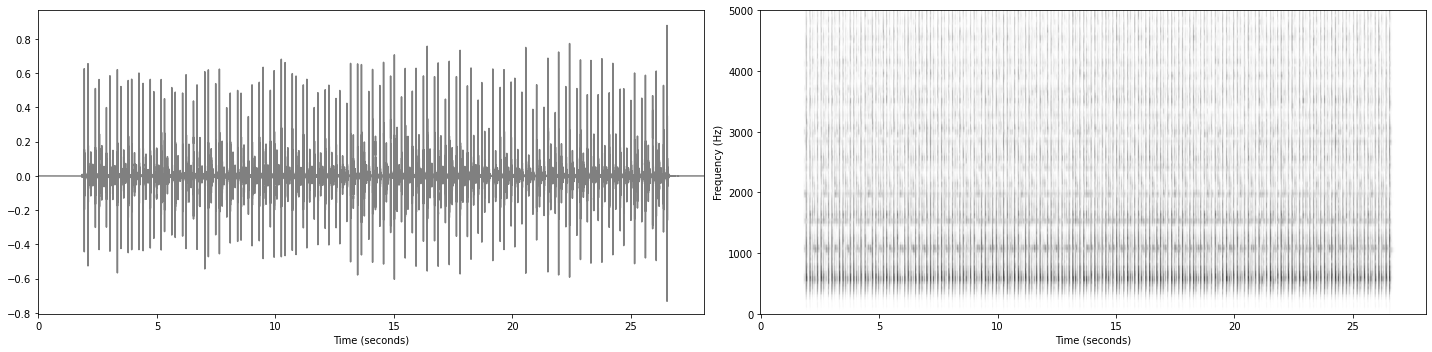

In [5]:
fn_wav = os.path.join('.', 'audio', audio_filename)
plot_wav_spectrogram(fn_wav)

### 2) Compute the novelty function

A type of derivative operator is applied to the feature sequence and a novelty function is derived. 

In this case, the novelty function is computed from the spectrogram of the audio signal in a way that captures certain changes in the spectrum.

In [6]:
x, Fs = librosa.load(fn_wav)

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs)

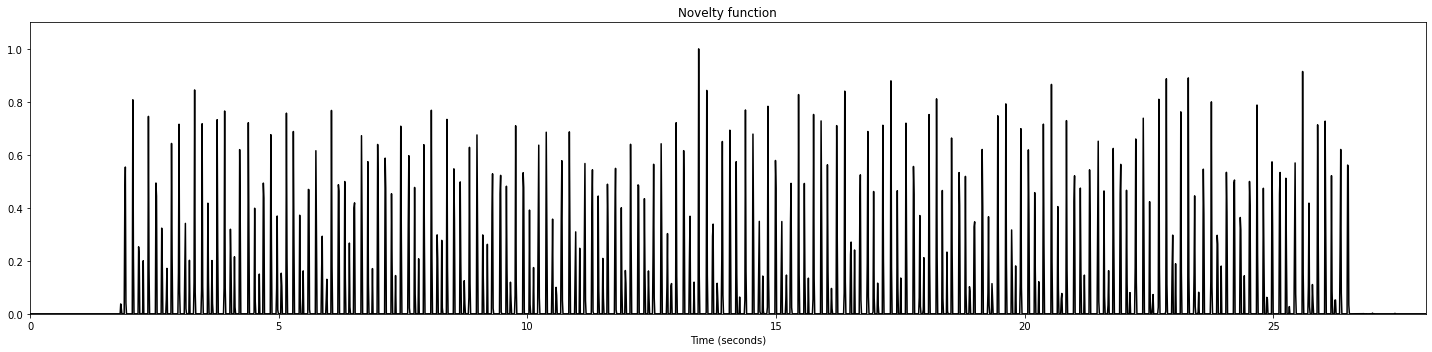

In [7]:
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', figsize=(20,5),
                                     title='Novelty function');
ax.set_xlabel('Time (seconds)')
plt.tight_layout()

### 3) Locate the onsets

A peak-picking algorithm is employed to locate the onset candidates.

In [8]:
prom_val=0.01

peaks, properties = signal.find_peaks(nov, prominence=prom_val)

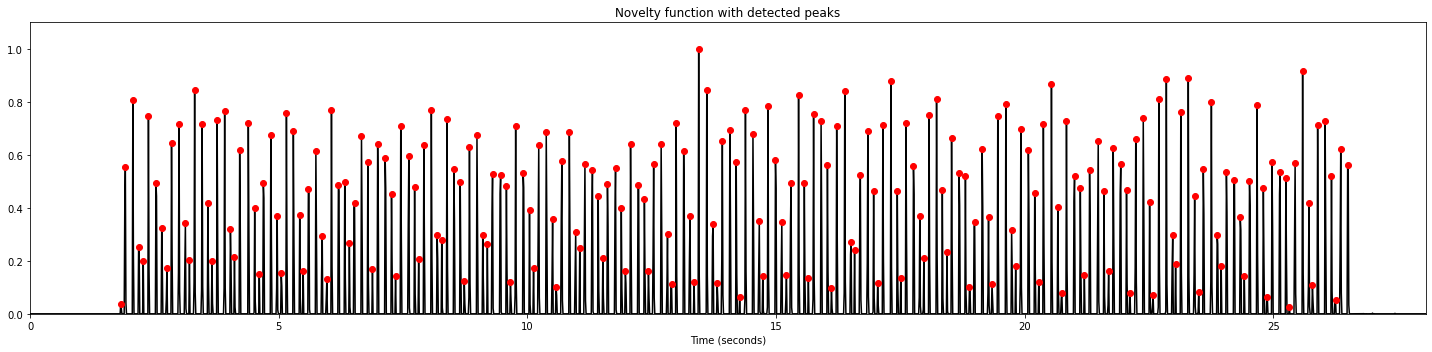

In [9]:
T_coef = np.arange(nov.shape[0]) / Fs_nov
peaks_sec = T_coef[peaks]
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', figsize=(20,5), 
                    title='Novelty function with detected peaks')
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()

### 4) Sonification of the onsets

Sonification of onset positions using click sounds for inspecting the accuracy of the onset detection. 

In [10]:
x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

## Proposed activity

Now that you have gone through the basics you should try to improve the obtained results. You may have noticed that the performance of the onset detection varies a lot for the different audio files available. This is reasonable since they exhibit different kind of onsets. Yoy could try to tweak some parameters of the technique in order to improve its performance.

### 1) Tweak the peak-picking threshold

We used a simple strategy to select peaks of the novelty function. There is a prominence threshold (`prom_val`) that allows us to select the most prominent peaks and ignore the other ones. You may want to adjust its value in order to improve the detection of onsets for some of the audio files provided. 

#### Select audio file

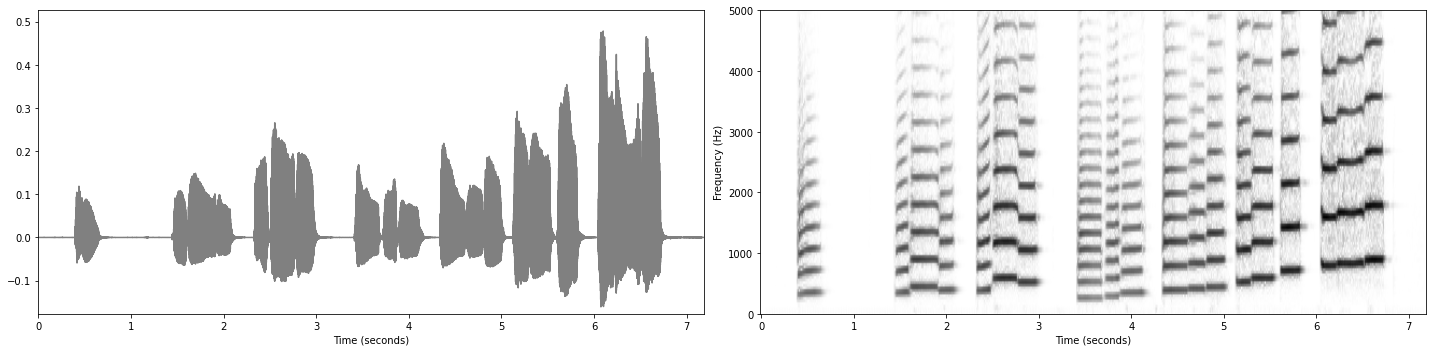

In [11]:
# audio_filename = 'tamborim.wav'
audio_filename = 'sir_duke_slow.wav'
# audio_filename = 'guitar.wav'
#audio_filename = 'sax.wav'

fn_wav = os.path.join('.', 'audio', audio_filename)
plot_wav_spectrogram(fn_wav)

#### Compute novelty function

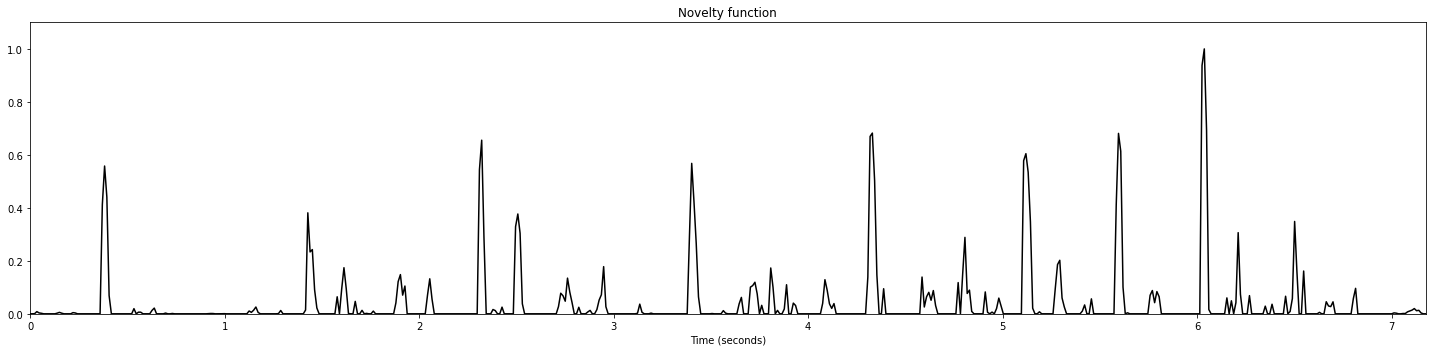

In [12]:
x, Fs = librosa.load(fn_wav)

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs)

fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', figsize=(20,5),
                                     title='Novelty function');
ax.set_xlabel('Time (seconds)')
plt.tight_layout()

#### Peak-picking to locate onsets

Here you should tweak the prominence threshold (`prom_val`). 

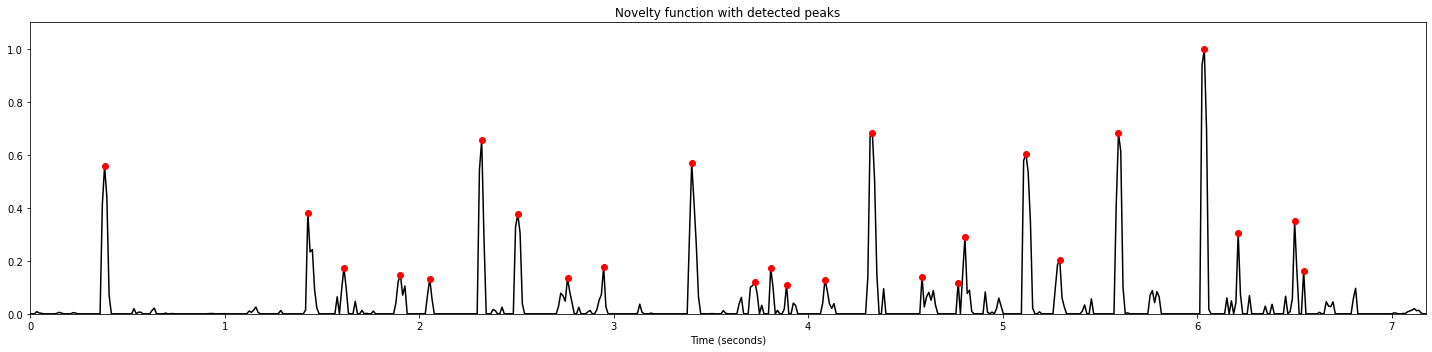

In [13]:
prom_val=0.10

peaks, properties = signal.find_peaks(nov, prominence=prom_val)

T_coef = np.arange(nov.shape[0]) / Fs_nov
peaks_sec = T_coef[peaks]
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', figsize=(20,5), 
                    title='Novelty function with detected peaks')
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()

#### Sonification of the onsets

In [14]:
x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

### 2) Tweak spectrogram parameters

The first step for computing the novelty function is to calculate a time-frequency representation of the audio signal. In this case we compute the discrete STFT using the sampling rate Fs, the window length N, and the hop size H. These parameters determine the time-frequency resolution of the STFT and hence have an important influence on the characteristics of the novelty function. 

Besides, it is common practice to apply logarithmic compression to the spectrum in order to enhance weak spectral components. In this implementation the parameter `gamma` controls the amount of logarithmic compression applied. 

Please refer to the [NoveltySpectral](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C6/C6S1_NoveltySpectral.html) notebook for further details and a complete explanation.

#### Select audio file

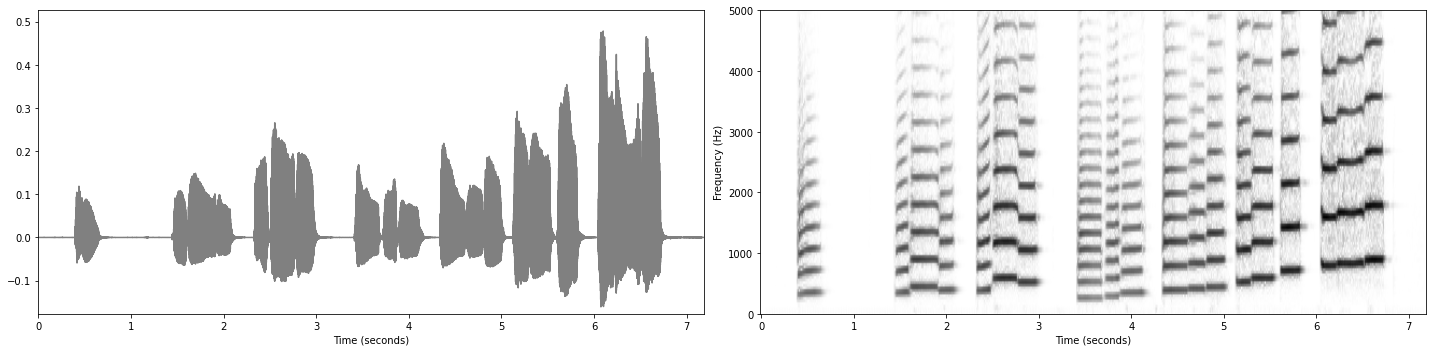

In [15]:
#audio_filename = 'tamborim.wav'
audio_filename = 'sir_duke_slow.wav'
# audio_filename = 'guitar.wav'
#audio_filename = 'sax.wav'

fn_wav = os.path.join('.', 'audio', audio_filename)
plot_wav_spectrogram(fn_wav, gamma=10)

#### Compute novelty function

Here you should also tweak the window length (`N`), hop length (`H`), and logarithmic compression constant (`gamma`). 

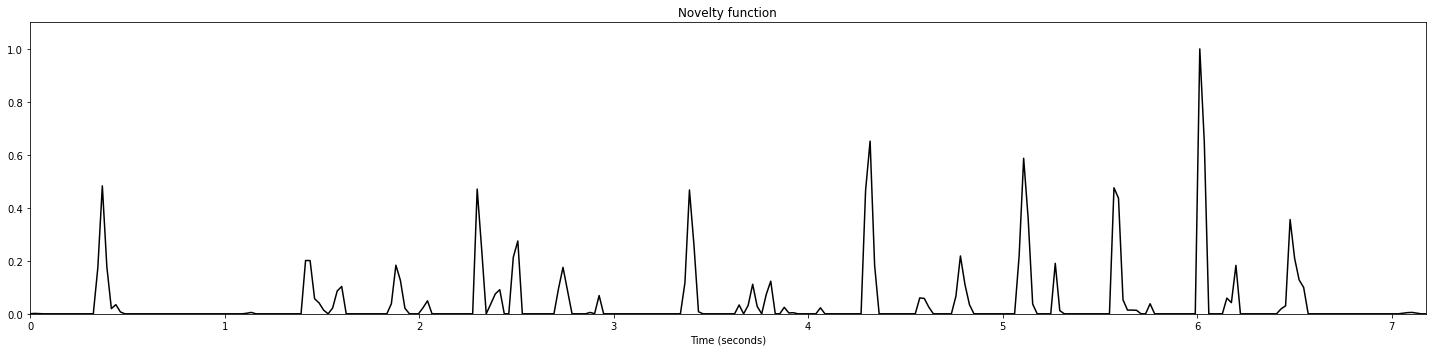

In [16]:
x, Fs = librosa.load(fn_wav)

N, H = 2048, 512
gamma = 10

nov, Fs_nov = libfmp.c6.compute_novelty_spectrum(x, Fs=Fs, N=N, H=H, gamma=gamma)

fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', figsize=(20,5),
                                     title='Novelty function');
ax.set_xlabel('Time (seconds)')
plt.tight_layout()

#### Peak-picking to locate onsets

Here you should also tweak the prominence threshold (`prom_val`). 

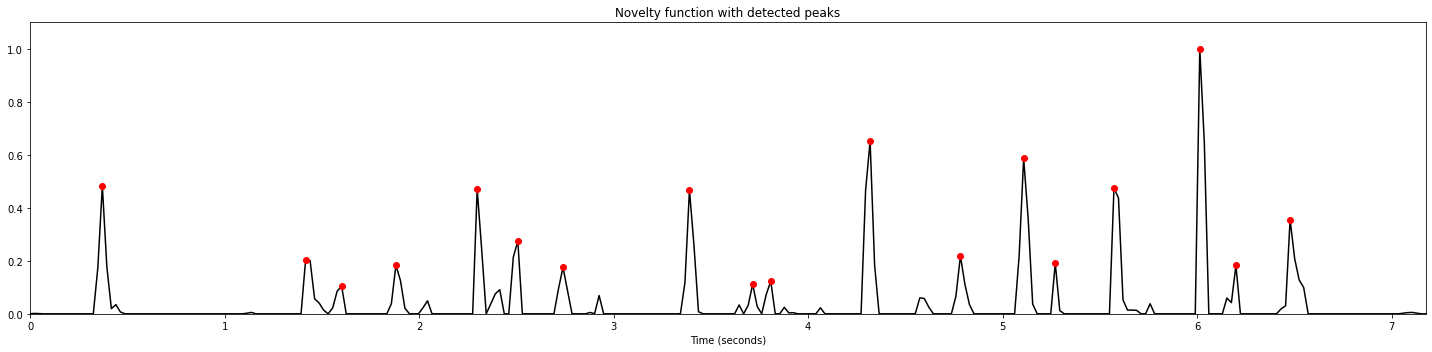

In [17]:
prom_val=0.10

peaks, properties = signal.find_peaks(nov, prominence=prom_val)

T_coef = np.arange(nov.shape[0]) / Fs_nov
peaks_sec = T_coef[peaks]
fig, ax, line = libfmp.b.plot_signal(nov, Fs_nov, color='k', figsize=(20,5), 
                    title='Novelty function with detected peaks')
plt.plot(peaks_sec, nov[peaks], 'ro')
plt.show()

#### Sonification of the onsets

In [18]:
x_peaks = librosa.clicks(peaks_sec, sr=Fs, click_freq=1000, length=len(x))
ipd.display(ipd.Audio(x + x_peaks, rate=Fs))

## Concluding remarks

There is no single approach for onset detection that is effective for every audio signal. You should probably need to adjust the parameters of the technique in order to better deal with the kind of onsets at hand.

Notice that we have just scratched the surface of the onset detection task. There several other approaches for computing the novelty detection function, for tweaking the audio signal representation, for post-processing the detection function, and for peak-picking. 

For those of you interested in going deeper the [Fundamentals of Music Processing (FMP)](https://www.audiolabs-erlangen.de/fau/professor/mueller/bookFMP) book (in particular Section 6.1) as well as the corresponding [FMP notebooks](https://www.audiolabs-erlangen.de/resources/MIR/FMP) are highly recommended.
